In [1]:
import os

import geopandas

import pandas as pd

import wget



def load_best_track(code='al14', year='2018'):
    fname = f'{code}{year}_best_track.zip'
    url = f'https://www.nhc.noaa.gov/gis/best_track/{fname}'

    if not os.path.isfile(fname):
        import wget
        fname = wget.download(url)

    os.environ['CPL_ZIP_ENCODING'] = 'UTF-8'

    radii = geopandas.read_file(
        f'/{code.upper()}{year}_radii.shp',
        vfs='zip://{}'.format(fname)
    )

    pts = geopandas.read_file(
        f'/{code.upper()}{year}_pts.shp',
        vfs='zip://{}'.format(fname)
    )
    radii.index = pd.to_datetime(radii['SYNOPTIME'], format='%Y%m%d%H', errors='coerce').values
    return radii, pts


radii, pts = load_best_track(code='al14', year='2018')
bbox = radii['geometry'].total_bounds

In [2]:
from datetime import datetime

min_lon, max_lon = bbox[0], bbox[2]
min_lat, max_lat = bbox[1], bbox[3]

bbox = [min_lon, min_lat, max_lon, max_lat]
crs = 'urn:ogc:def:crs:OGC:1.3:CRS84'

start = datetime(2018, 10, 7, 0, 0, 0)
stop = datetime(2018, 10, 16, 0, 0, 0)

# Sea surface temperature CF names.
cf_names = ['sea_water_temperature',
            'sea_surface_temperature',
            'sea_water_potential_temperature',
            'equivalent_potential_temperature',
            'sea_water_conservative_temperature',
            'pseudo_equivalent_potential_temperature']

In [3]:
def fes_date_filter(start, stop, constraint='overlaps'):
    from owslib import fes
    start = start.strftime('%Y-%m-%d %H:00')
    stop = stop.strftime('%Y-%m-%d %H:00')
    if constraint == 'overlaps':
        propertyname = 'apiso:TempExtent_begin'
        begin = fes.PropertyIsLessThanOrEqualTo(propertyname=propertyname,
                                                literal=stop)
        propertyname = 'apiso:TempExtent_end'
        end = fes.PropertyIsGreaterThanOrEqualTo(propertyname=propertyname,
                                                 literal=start)
    elif constraint == 'within':
        propertyname = 'apiso:TempExtent_begin'
        begin = fes.PropertyIsGreaterThanOrEqualTo(propertyname=propertyname,
                                                   literal=start)
        propertyname = 'apiso:TempExtent_end'
        end = fes.PropertyIsLessThanOrEqualTo(propertyname=propertyname,
                                              literal=stop)
    else:
        raise NameError('Unrecognized constraint {}'.format(constraint))
    return begin, end

In [4]:
from owslib import fes

kw = dict(
    wildCard='*',
    escapeChar='\\',
    singleChar='?',
    propertyname='apiso:AnyText'
)

or_filt = fes.Or(
    [fes.PropertyIsLike(literal=('*%s*' % val), **kw)
        for val in cf_names])

begin, end = fes_date_filter(start, stop)
bbox_crs = fes.BBox(bbox, crs=crs)

filter_list = [
    fes.And(
        [
            bbox_crs,
            begin, end,
            or_filt,
            fes.Not([fes.PropertyIsLike(literal='*cdip*', **kw)]),
        ]
    )
]

In [5]:
def get_csw_records(csw, filter_list, pagesize=10, maxrecords=1000):
    """Iterate `maxrecords`/`pagesize` times until the requested value in
    `maxrecords` is reached.
    """
    from owslib.fes import SortBy, SortProperty
    # Iterate over sorted results.
    sortby = SortBy([SortProperty('dc:title', 'ASC')])
    csw_records = {}
    startposition = 0
    nextrecord = getattr(csw, 'results', 1)
    while nextrecord != 0:
        csw.getrecords2(constraints=filter_list, startposition=startposition,
                        maxrecords=pagesize, sortby=sortby)
        csw_records.update(csw.records)
        if csw.results['nextrecord'] == 0:
            break
        startposition += pagesize + 1  # Last one is included.
        if startposition >= maxrecords:
            break
    csw.records.update(csw_records)

In [6]:
from owslib.csw import CatalogueServiceWeb


endpoint = 'https://data.ioos.us/csw'

csw = CatalogueServiceWeb(endpoint, timeout=60)

get_csw_records(csw, filter_list, pagesize=10, maxrecords=1000)

records = '\n'.join(csw.records.keys())
print('Found {} records.\n'.format(len(csw.records.keys())))

Found 507 records.



In [7]:
for key, value in list(csw.records.items()):
    print(u'[{}]\n{}\n'.format(value.title, key))

[WRBF1 Whipray Basin, FL]
gov_nps_ever_wrbf1

[Wrightsville Beach, NC]
noaa_nos_co_ops_8658163

[Wrightsville Beach Nearshore, NC (ILM2)]
sdf.ndbc.noaa.gov-urn_ioos_station_wmo_41038

[Wrightsville Beach Offshore, NC (ILM3)]
sdf.ndbc.noaa.gov-urn_ioos_station_wmo_41037

[WWEF1 White Water -West, FL]
gov_nps_ever_wwef1

[York Spit, VA]
sdf.ndbc.noaa.gov-urn_ioos_station_wmo_44072

[Zeke's Basin]
nerrs_noczbwq

[* 2nd Avenue Pier]
edu_ccu_lbos_2nd_ave_pier

[41002 SOUTH HATTERAS - 225 NM South of Cape Hatteras]
wmo_41002

[41004 EDISTO - 41 NM Southeast of Charleston, SC]
wmo_41004

[41008 GRAYS REEF - 40 NM Southeast of Savannah, GA]
university_of_georgia_uga_41008

[41009 CANAVERAL 20 NM East of Cape Canaveral, FL]
wmo_41009

[41010 CANAVERAL EAST - 120NM East of Cape Canaveral]
wmo_41010

[41013 Frying Pan Shoals, NC Buoy]
wmo_41013

[* 41024 / SUN2 Sunset Nearshore]
org_cormp_sun2

[41024 / SUN2 Sunset Nearshore - sea_water_temperature]
org.cormp:sun2:sea_water_temperature

[41024 / 

In [8]:
import textwrap


key, value = list(csw.records.items())[-1]

# print('\n'.join(textwrap.wrap(value.abstract)))
value.abstract

"Timeseries data from '(WIWF1) Willy Willy, FL' (urn:ioos:station:gov.nps.ever:WIWF1)"

In [9]:
print('\n'.join(value.subjects))

earth science
atmosphere
ocean
biosphere
biology
environment
Everglades National Park
time
latitude
longitude
sea_water_practical_salinity
sea_water_temperature
sea_water_temperature
sea_surface_height_above_sea_level
depth
depth
geoscientificInformation


In [10]:
from geolinks import sniff_link

msg = 'geolink: {geolink}\nscheme: {scheme}\nURL: {url}\n'.format
for ref in value.references:
    print(msg(geolink=sniff_link(ref['url']), **ref))

geolink: WWW:LINK
scheme: order
URL: http://erddap.secoora.org/erddap/tabledap/gov_nps_ever_wiwf1.html

geolink: None
scheme: order
URL: http://erddap.secoora.org/erddap/tabledap/gov_nps_ever_wiwf1.graph

geolink: None
scheme: .html
URL: http://erddap.secoora.org/erddap/tabledap/gov_nps_ever_wiwf1

geolink: None
scheme: .html
URL: http://erddap.secoora.org/erddap/tabledap/gov_nps_ever_wiwf1



In [11]:
fmt = ('http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?'
       'service=SOS&'
       'eventTime={0:%Y-%m-%dT00:00:00}/{1:%Y-%m-%dT00:00:00}&'
       'observedProperty=http://mmisw.org/ont/cf/parameter/sea_water_temperature&'
       'version=1.0.0&'
       f'request=GetObservation&offering=urn:ioos:station:NOAA.NOS.CO-OPS:8728690&'
       'responseFormat=text/csv')

url = fmt.format(start, stop)

In [12]:
import pandas as pd

df = pd.read_csv(
    url,
    index_col='date_time', parse_dates=True
)

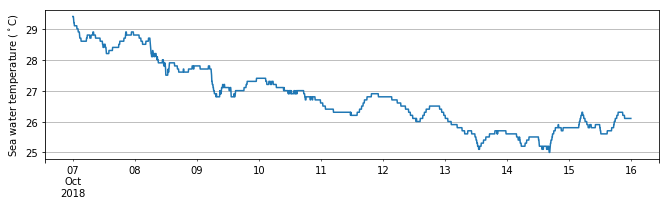

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(11, 2.75))
ax = df['sea_water_temperature (C)'].plot(ax=ax)
ax.set_xlabel('')
ax.grid(True)
ax.set_ylabel(r'Sea water temperature ($^\circ$C)');